In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ift6758/data/milestone2/q3_baseline
import sys
sys.path.append('../ift6758/data/milestone2')

    

In [2]:
from q6_plot import read_all_features,\
                        plot_models

In [3]:
# part 3 - q1 we got 90.39%, 
# part 5.2 got 91.27%
# part 6 needs to be greater than 90.39%

In [4]:
dataset = pd.read_csv('/Users/xiaoxinzhou/Documents/IFT6758_M2_CSV_data/all_data_categorical.csv')
X = dataset.iloc[: , :-1]
y = dataset[['Is Goal']]

In [ ]:
##############################################################################
# Approch 1: Decision Tree Classifier
##############################################################################

In [42]:
def tree_train(X, y):
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=50)    
    
    clf = DecisionTreeClassifier(
                        max_leaf_nodes=3, 
                        max_depth=30,
                        random_state=0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))  
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    print(f"roc_auc: {roc_auc}")
    
tree_train(X, y)

Accuracy: 91.23%
roc_auc: 0.5223592906707787


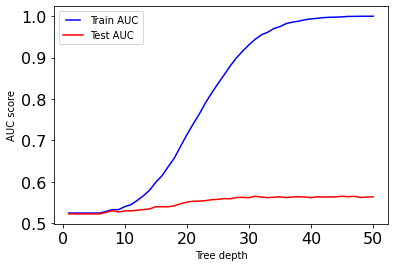

In [6]:
# ref: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
def tree_tune_max_path():
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=50) 
    
    max_depths = np.linspace(1, 50, 50, endpoint=True)
    train_results = []
    test_results = []
    
    for max_depth in max_depths:
        dt = DecisionTreeClassifier(max_depth=max_depth)
        dt.fit(X_train, y_train)
        train_pred = dt.predict(X_train)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)

        # Add auc score to previous train results
        train_results.append(roc_auc)
        y_pred = dt.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)


        # Add auc score to previous test results
        test_results.append(roc_auc)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('Tree depth')
    plt.show()   
tree_tune_max_path()    

No handles with labels found to put in legend.


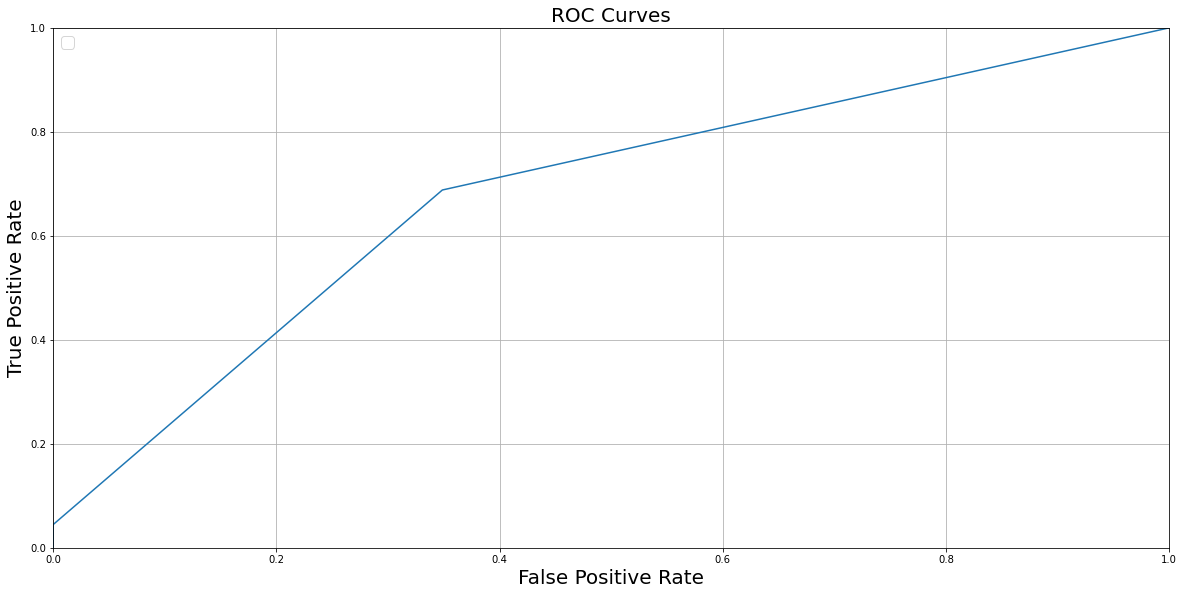

No handles with labels found to put in legend.


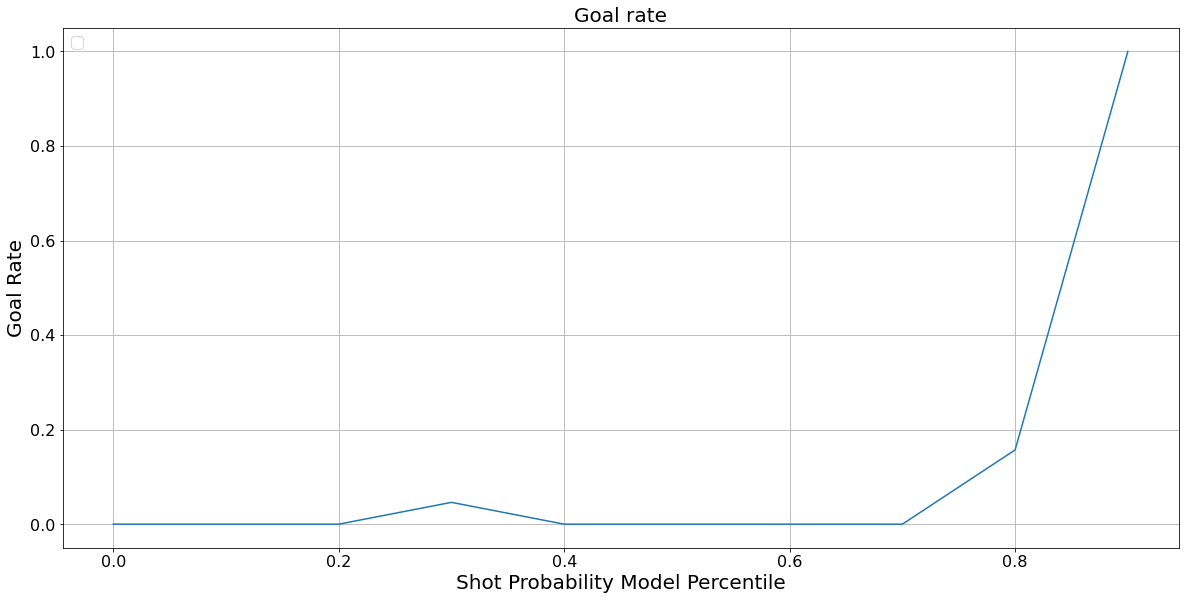

No handles with labels found to put in legend.


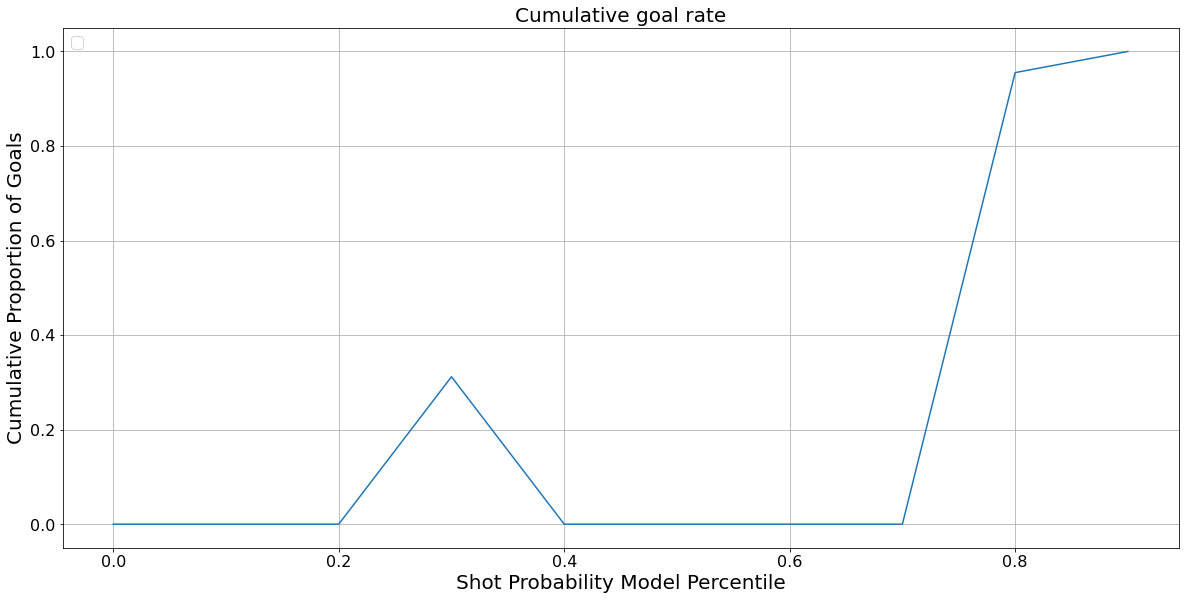

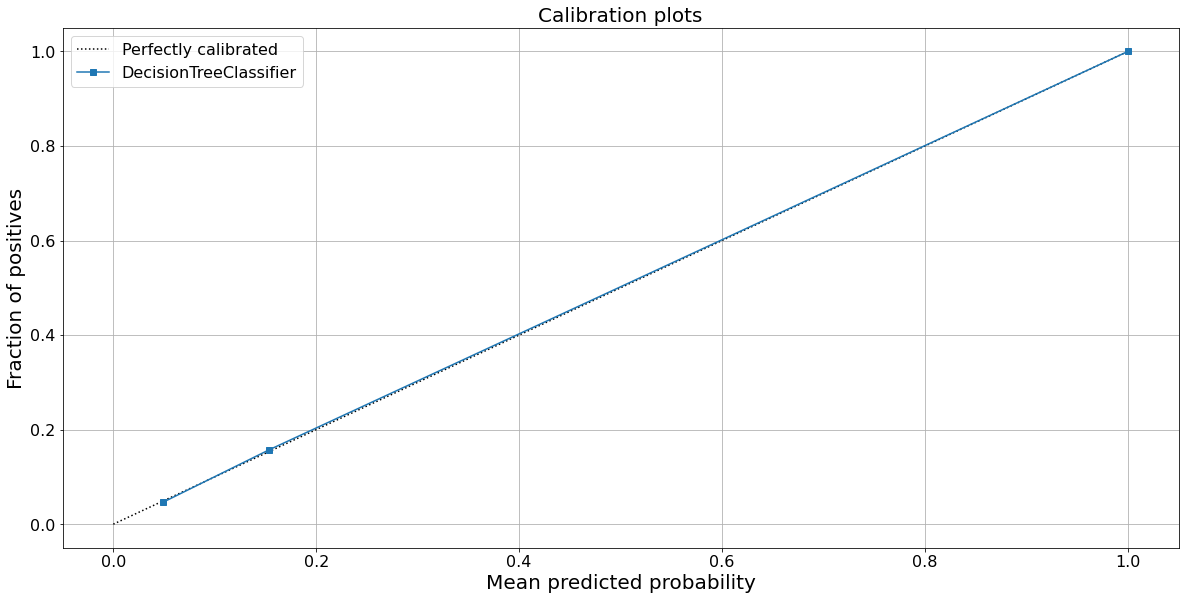

In [5]:
plot_models(X,y,'decision_tree')

In [11]:
##############################################################################
# Approch 2: Regularization: Lasso Regression
# 
# ref: https://harish-reddy.medium.com/regularization-in-python-699cfbad8622
##############################################################################
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

def lasso_train(X, y):
    
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=50) 
    
    lassoreg = Lasso(alpha=0.001, normalize=True)
    lassoreg.fit(X_train, y_train)
    
    print(f"Lasso score: {lassoreg.score(X_test, y_test)}")
    
    # y_pred = lassoreg.predict(X_test)
    
    # accuracy = metrics.accuracy_score(y_test, y_pred)
    # print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # print("R-Square Value",r2_score(y_test,y_pred))
    # print("\n")
    # print ("mean_absolute_error :",metrics.mean_absolute_error(y_test, y_pred))
    # print("\n")
    # print ("mean_squared_error : ",metrics.mean_squared_error(y_test, y_pred))
    # print("\n")
    # print ("root_mean_squared_error : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
lasso_train(X, y)    

/usr/local/Caskroom/miniforge/base/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso score: -2.270281776350913e-06


In [13]:
##############################################################################
# Approch 3: Hyperparameter tuning, cross validation strategies 
# 
# ref: 
# - https://scikit-learn.org/stable/modules/cross_validation.html
# - https://www.jeremyjordan.me/hyperparameter-tuning/
# - https://ai.plainenglish.io/hyperparameter-tuning-of-decision-tree-classifier-using-gridsearchcv-2a6ebcaffeda
##############################################################################
from sklearn.model_selection import GridSearchCV

def tree2_train(X, y, features=['Distance from Net']):
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[features],
                                                        y,
                                                        test_size=0.20,
                                                        random_state=50)    
    
    clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
    clf.fit(X_train, y_train)
    
    # Cross validation with 10 folds
    scores = cross_val_score(clf, X, y, cv=10) 
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    # Grid search
    param_dict = {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(1, 10),
        'min_samples_split': range(1, 10),
        'min_samples_leaf': range(1, 5)
        }
    
    grid = GridSearchCV(clf,
                       param_grid=param_dict,
                       cv=10,
                       verbose=1,
                       n_jobs=-1)
    
    grid.fit(X_train, y_train)
    print(f"grid best params: {grid.best_params_}")
    print(f"grid best estimator: {grid.best_estimator_}")
    print(f"grid best score: {grid.best_score_}")
    
tree2_train(X, y)    

0.91 accuracy with a standard deviation of 0.00
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
grid best params: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
grid best estimator: DecisionTreeClassifier(max_depth=1, max_leaf_nodes=3, random_state=0)
grid best score: 0.9067396860188456


/usr/local/Caskroom/miniforge/base/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
720 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniforge/base/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/Caskroom/miniforge/base/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/Caskroom/miniforge/base/envs/ift6758-conda-env